# Photometric redshifts of galaxies

In [124]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table
import seaborn as sns
sns.set(style="white")
# Import all libraries
%matplotlib inline 

In [125]:
#Read de data from the two tables (Named A and B)

A = Table.read('/home/juancho/Master/Semester3/DBDM/DDM2017_FinalProject/FinalProject/Q2/Tables/PhotoZFileA.vot').to_pandas()
B = Table.read('/home/juancho/Master/Semester3/DBDM/DDM2017_FinalProject/FinalProject/Q2/Tables/PhotoZFileB.vot').to_pandas()


In [126]:
# From the colours I can get the magnitudes

# First for table A
A['i'] = A['mag_r'].values - A["r-i"].values
A['z'] = A['i'].values - A["i-z"].values
A['g'] = A['mag_r'].values + A["g-r"].values
A['u'] = A['g'].values + A["u-g"].values

# Now for B
B['i'] = B['mag_r'].values - B["r-i"].values
B['z'] = B['i'].values - B["i-z"].values
B['g'] = B['mag_r'].values + B["g-r"].values
B['u'] = B['g'].values + B["u-g"].values

In [127]:
#Stack the data
X = np.vstack((A['mag_r'].values, A['i'].values, A['z'].values, A['g'].values, A['u'].values,A['z_spec'].values)).T
M = np.vstack((A['mag_r'].values, A['i'].values, A['z'].values, A['g'].values, A['u'].values)).T

Zspec=A['z_spec'].values

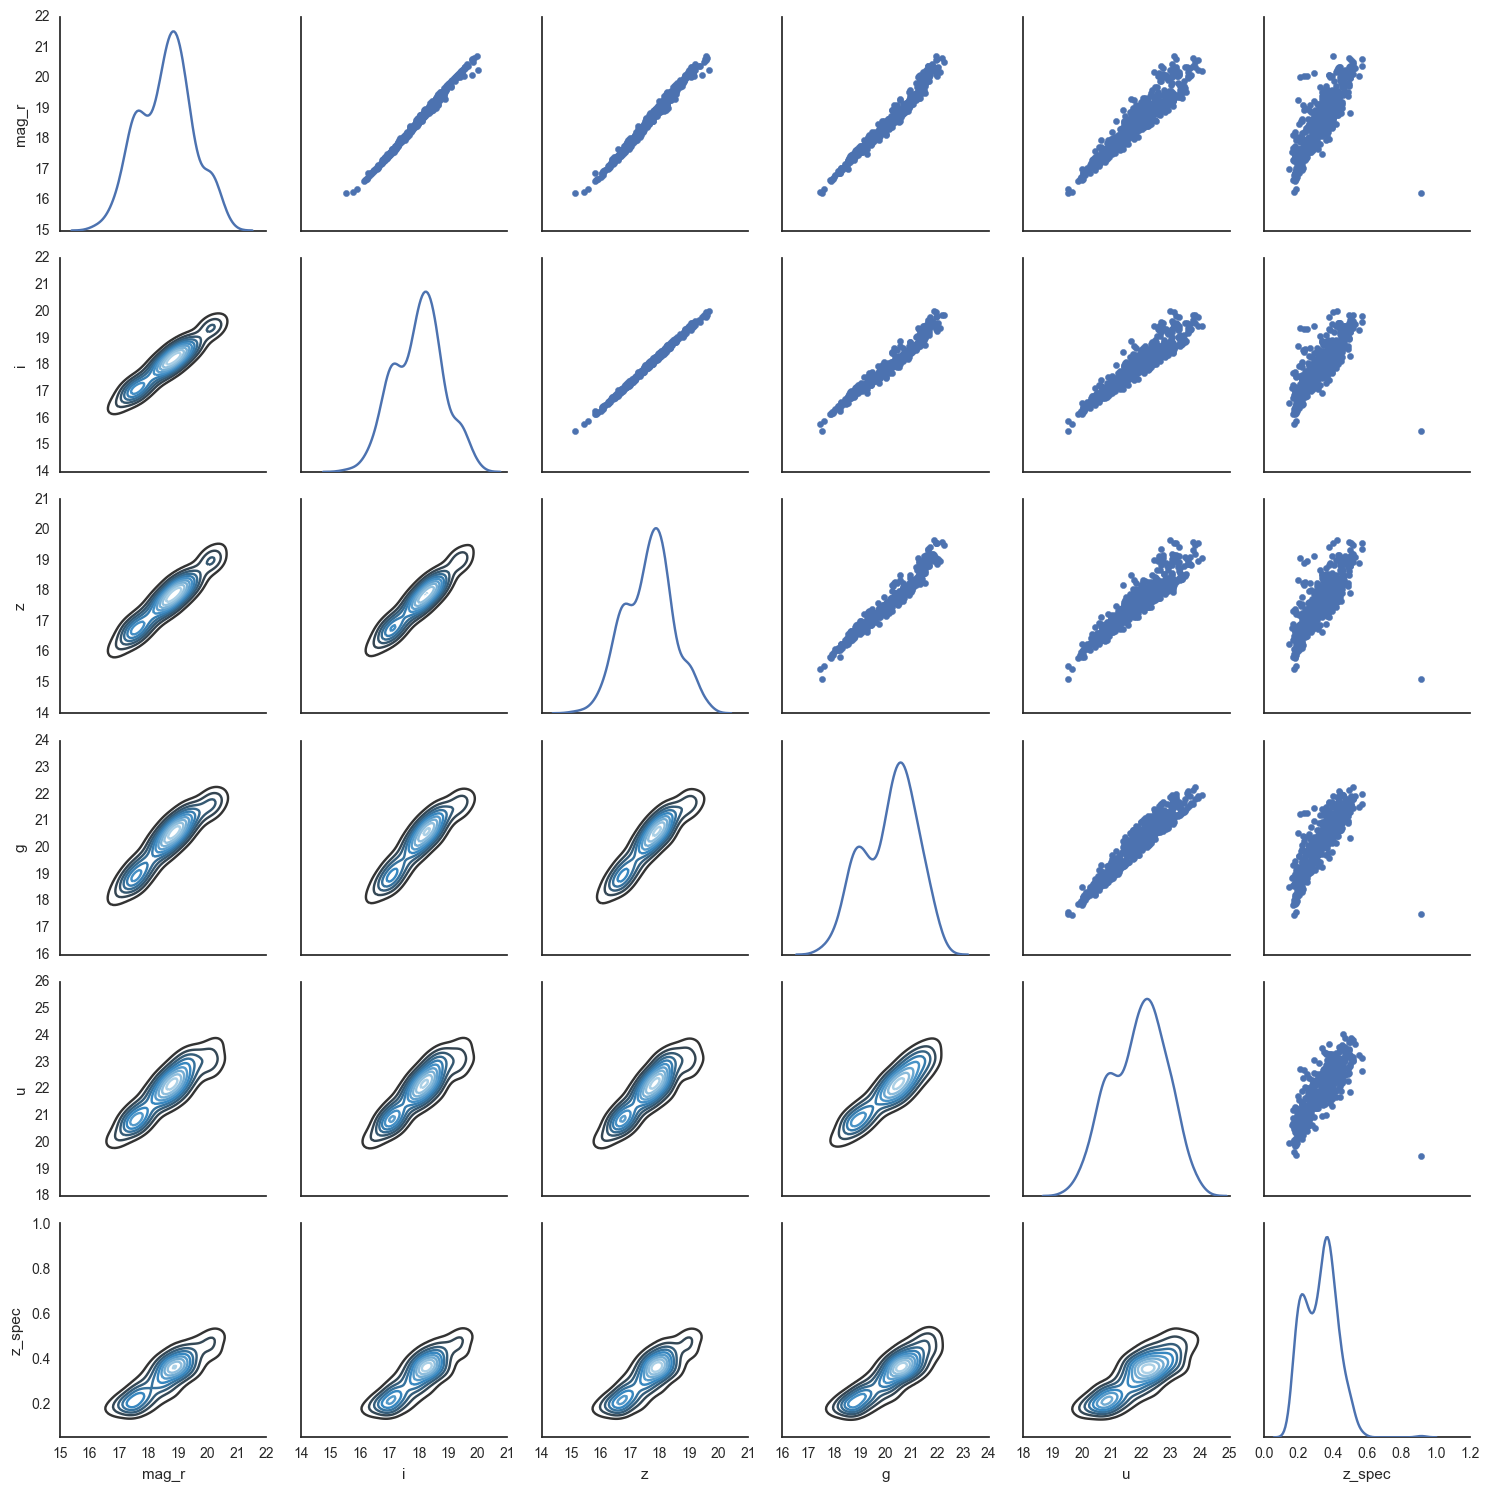

In [128]:
# Here I make a Pandas's DataFrame 
df = pd.DataFrame(X[0:500, :], columns=['mag_r','i','z','g','u','z_spec'])
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot)

# Ridge

In [129]:
from sklearn.linear_model import Ridge

In [130]:
# I am using the standard setup for fitting as done by Jarle in the lecture notes and exercises
# For Ridge regression I varied the values of alpha and found that the best results and smakller errors 
# were achieved with alpha = 0.0001
model = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
res = model.fit(M, Zspec)
Zpred_ridge = model.predict(M)
residuals_ridge = Zpred_ridge-Zspec
relative_residuals_ridge = residuals_ridge/Zspec

# Here I get the values of the coefficients after the regression is made.
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]

# Define the training error as
Error_ridge = np.median( np.abs( (Zspec - Zpred_ridge)/(1.0 + Zspec) ) )

print " The best-fit model in the Ridge model is:\n z_phot = {0:.3f}+ {1:.3f} (r) + {2:.3f} (i) + {3:.3f} (z) + {4:.3f} (g) + {4:.3f} (u)".format(c[0], c[1], c[2], c[3], c[4])
print("\n The error is:\n\n   E = %f"%Error_ridge)

 The best-fit model in the Ridge model is:
 z_phot = -0.801+ 0.353 (r) + -0.364 (i) + -0.033 (z) + 0.097 (g) + 0.097 (u)

 The error is:

   E = 0.014610


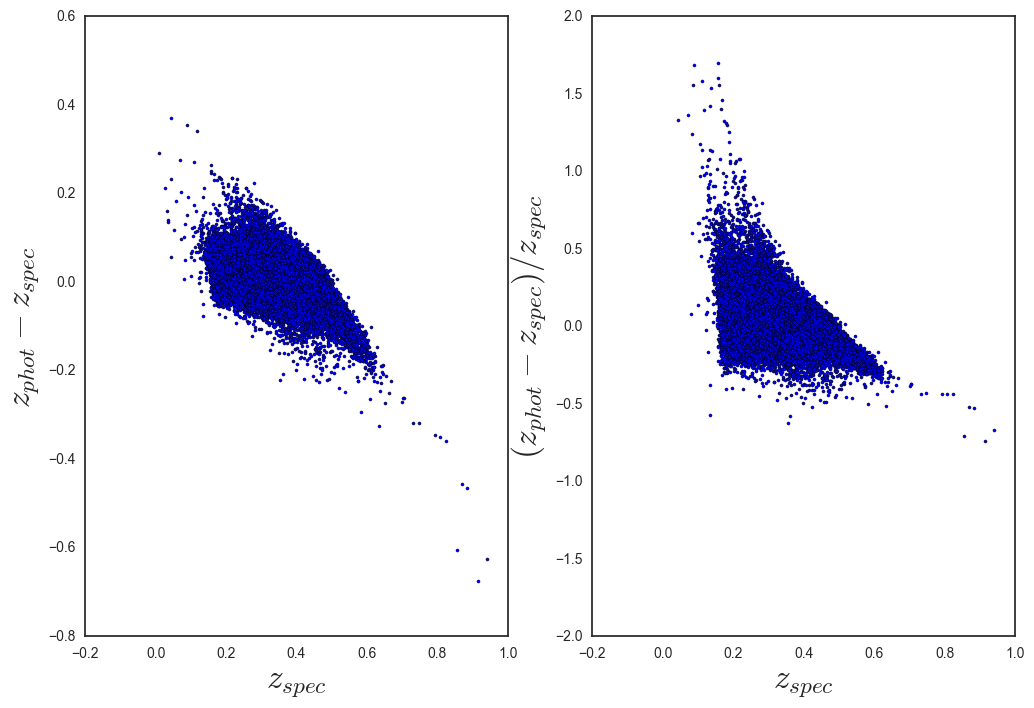

In [131]:
# Plot the discrapancy and the relative residuals
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
axes[0].scatter(Zspec, residuals_ridge, marker='.')
axes[0].set_xlabel(r'$z_{spec}$', size=24)
axes[0].set_ylabel(r'$z_{phot}-z_{spec}$', size=24)

axes[1].scatter(Zspec, relative_residuals_ridge, marker='.')
axes[1].set_xlabel(r'$z_{spec}$', size=24)
axes[1].set_ylim(-2,2)
axes[1].set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24)

In [132]:
# Here I define the function that calculates the median on the data to clearly see how simetric the relative 
# residuals are with respect to 0

def running_median(x, y, N=None, binsize=None):

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # To get the bins and their positions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

In [133]:
# Actually get the median
Zspec_m_ridge, med_ridge, bins = running_median(Zspec, relative_residuals_ridge, N = 5, binsize = 0.15)

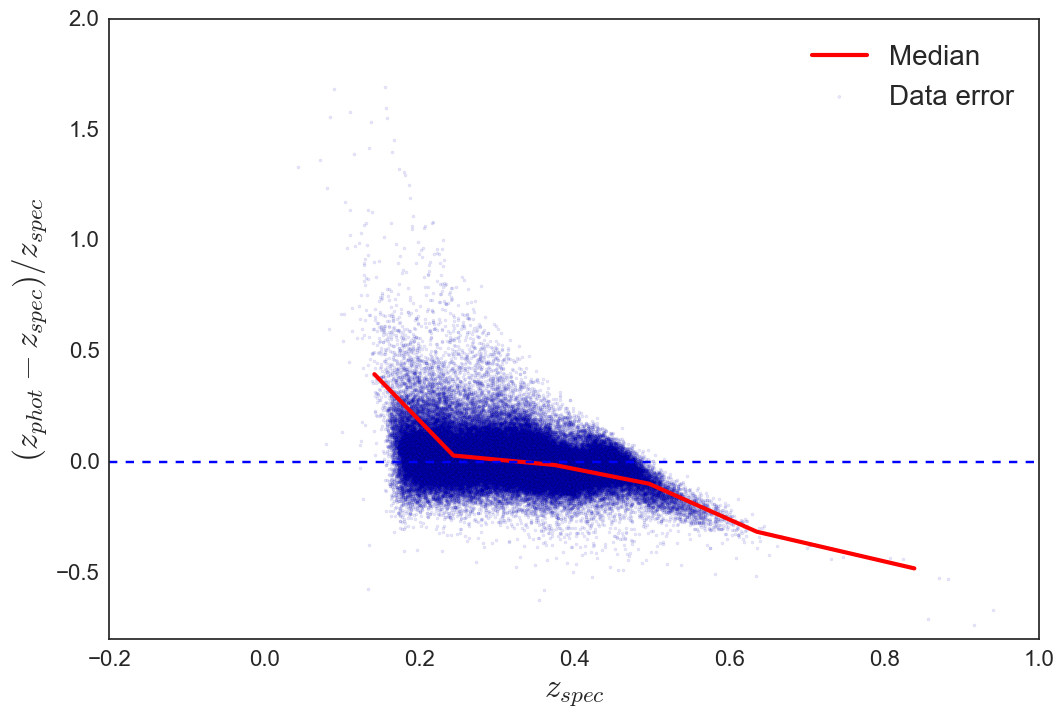

In [134]:
# Plot the relative residuals and the median 
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.scatter(Zspec, relative_residuals_ridge, marker='.', alpha=0.1, label="Data error")
ax.plot(Zspec_m_ridge, med_ridge, lw=3, color='red', label="Median")

ax.set_xlabel(r'$z_{spec}$', size=24)
ax.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.8,2)
ax.axhline(y=0.0, linestyle= '--')
ax.legend(prop={'size': 20})

# LASSO

In [135]:
from sklearn.linear_model import Lasso

In [136]:
# For Lasso the best fit is achieved with alpha = 0.000001
model = Lasso(alpha=0.000001, fit_intercept=True, normalize=True)
res = model.fit(M, Zspec)
Zpred_lasso = model.predict(M)
residuals_lasso = Zpred_lasso-Zspec
relative_residuals_lasso = residuals_lasso/Zspec

# Get the coefficients.
c = [res.intercept_]
[c.append(coeff) for coeff in res.coef_]
# Same procedure as Ridge regression from now on so I won't repeat the same comments
Error_lasso = np.median( np.abs( (Zspec - Zpred_lasso)/(1.0 + Zspec) ) )

print " The best-fit model in the Lasso model is:\n z_phot = {0:.3f}+ {1:.3f} (r) + {2:.3f} (i) + {3:.3f} (z) + {4:.3f} (g) + {4:.3f} (u)".format(c[0], c[1], c[2], c[3], c[4])
print("\n The error is:\n\n   E = %g"%Error_lasso)

 The best-fit model in the Lasso model is:
 z_phot = -0.956+ 0.215 (r) + -0.194 (i) + -0.059 (z) + 0.098 (g) + 0.098 (u)

 The error is:

   E = 0.0155897


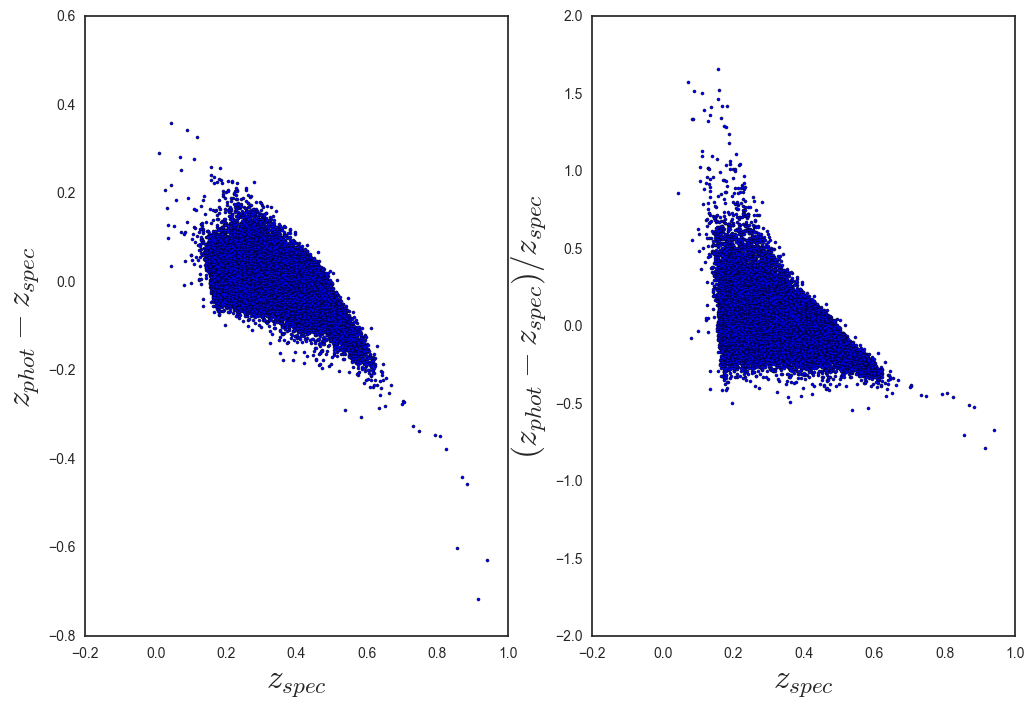

In [137]:
# Plot the discrapancy and the relative residuals
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
axes[0].scatter(Zspec, residuals_lasso, marker='.')
axes[0].set_xlabel(r'$z_{spec}$', size=24)
axes[0].set_ylabel(r'$z_{phot}-z_{spec}$', size=24)

axes[1].scatter(Zspec, relative_residuals_lasso, marker='.')
axes[1].set_xlabel(r'$z_{spec}$', size=24)
axes[1].set_ylim(-2,2)
axes[1].set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24)

In [138]:
# Here I define the median on the data to clearly see how simetric the relative residuals are with respect to 0

def running_median(x, y, N=None, binsize=None):

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # To get the bins and their positions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

In [139]:
Zspec_m_lasso, med_lasso, bins = running_median(Zspec, relative_residuals_lasso, N = 5, binsize = 0.15)

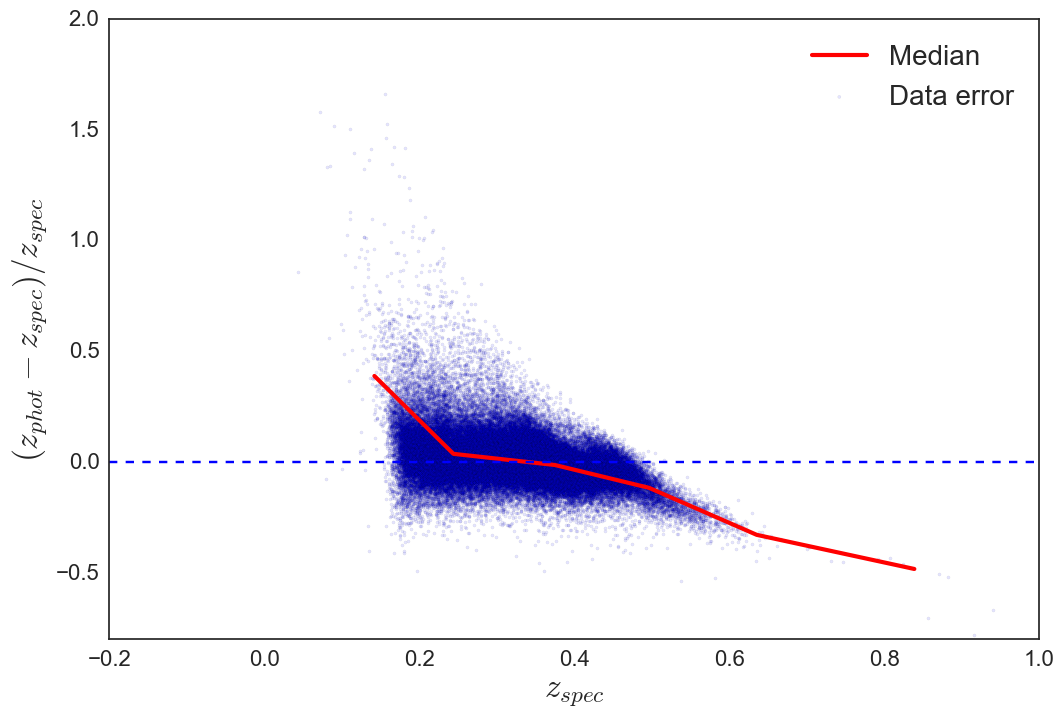

In [140]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.scatter(Zspec, relative_residuals_lasso, marker='.', alpha=0.1, label="Data error")
ax.plot(Zspec_m_lasso, med_lasso, lw=3, color='red', label="Median")

ax.set_xlabel(r'$z_{spec}$', size=24)
ax.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.8,2)
ax.axhline(y=0.0, linestyle= '--')
ax.legend(prop={'size': 20})

# Linear regression

In [141]:
from astroML.datasets import fetch_sdss_sspp
from astroML.plotting import hist
from astroML.linear_model import LinearRegression

In [142]:
# I use astroML for linear regression. Here it's not neccesary to specify the regularization strength since it's
# already set to zero (alpha=0)

model = LinearRegression(fit_intercept=True)
res = model.fit(M, Zspec)
Zpred_lin = model.predict(M)
c = list(res.coef_)
residuals_lin = Zpred_lin-Zspec
relative_residuals_lin = residuals_lin/Zspec

Error_lin = np.median( np.abs( (Zspec - Zpred_lin)/(1.0 + Zspec) ) )
print " The best-fit model is:\n z_phot = {0:.3f}+ {1:.3f} (r) + {2:.3f} (i) + {3:.3f} (z) + {4:.3f} (g) + {4:.3f} (u)".format(c[0], c[1], c[2], c[3], c[4])
print("\n The error is:\n\n E = {}\n".format(Error_lin))

 The best-fit model is:
 z_phot = -0.783+ 0.372 (r) + -0.395 (i) + -0.021 (z) + 0.096 (g) + 0.096 (u)

 The error is:

 E = 0.0145588611233



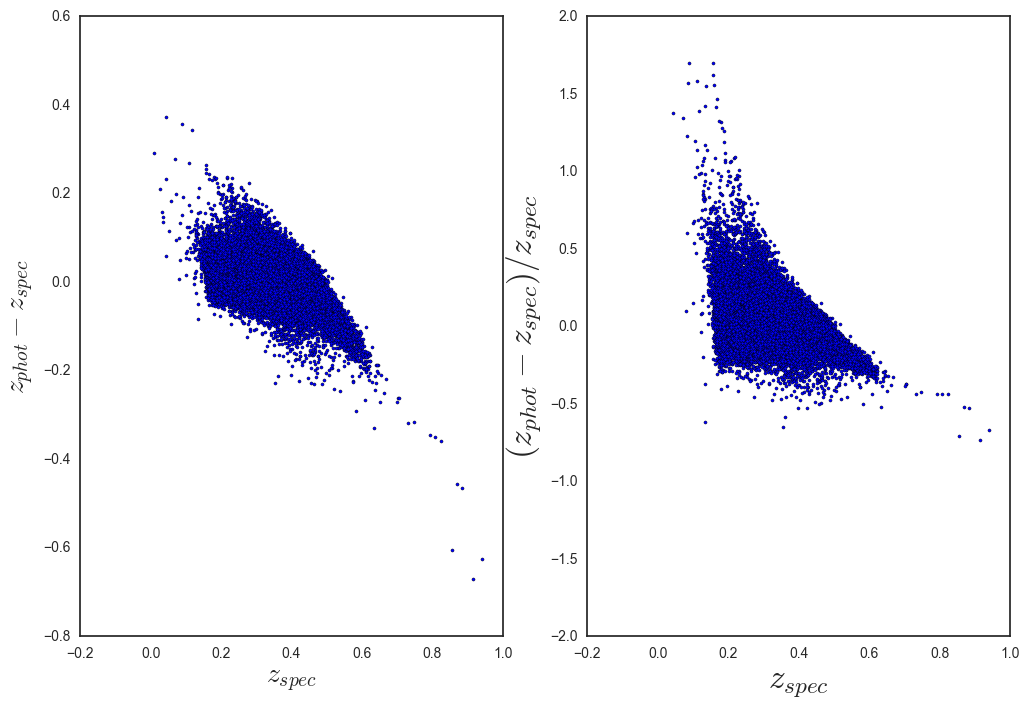

In [143]:
# Plot the discrapancy and the relative residuals for linear regression
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 8))
axes[0].scatter(Zspec, residuals_lin, marker='.')
axes[0].set_xlabel(r'$z_{spec}$', size=20)
axes[0].set_ylabel(r'$z_{phot}-z_{spec}$', size=20)

axes[1].scatter(Zspec, relative_residuals_lin, marker='.')
axes[1].set_xlabel(r'$z_{spec}$', size=24)
axes[1].set_ylim(-2,2)
axes[1].set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24)

In [144]:
# Here I define the median (tha same way as for the other methods)

def running_median(x, y, N=None, binsize=None):

    if binsize is not None:
        bins = np.arange(x.min(), x.max(), binsize)
        N = len(bins)
    else:
        bins = np.linspace(x.min(), x.max(), N)
        binsize = bins[1]-bins[0]
        
    # To get the bins and their positions.
    idx  = np.digitize(x, bins)
    
    r_med = [np.median(y[idx==k]) for k in range(N)]
    x_bins = [np.mean(x[idx==k]) for k in range(N)]
    
    return np.array(x_bins), np.array(r_med), bins

In [145]:
Zspec_m_lin, med_lin, bins = running_median(Zspec, relative_residuals_lin, N = 5, binsize = 0.15)

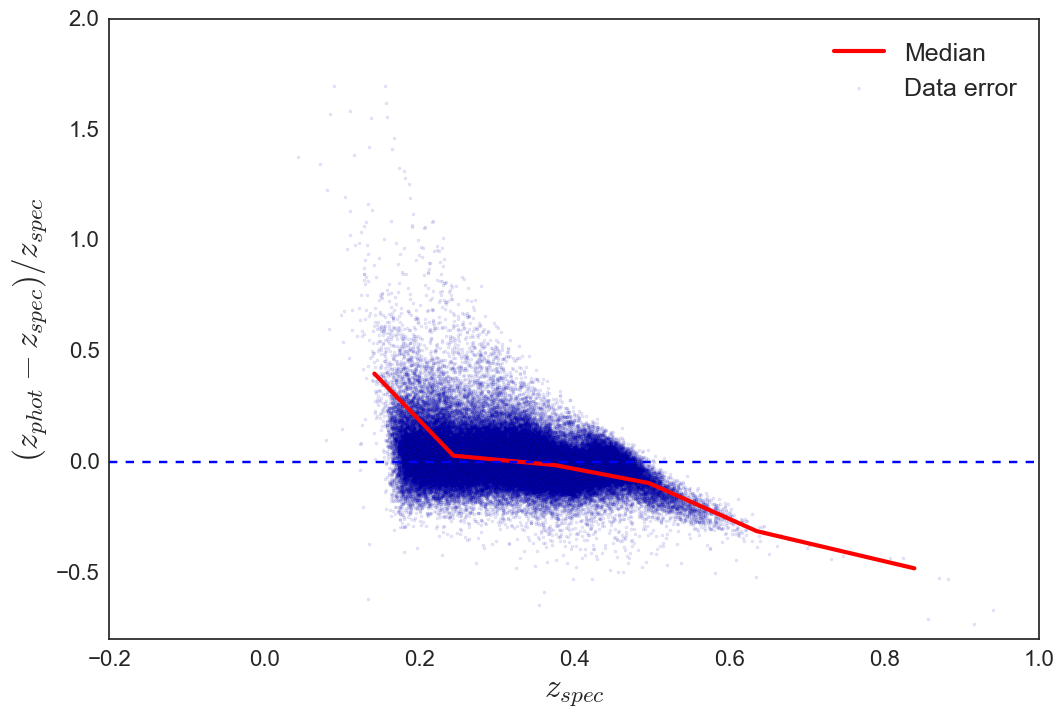

In [146]:
# Plot the relative residuals and the median trend line for linear regression

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 8))
ax.scatter(Zspec, relative_residuals_lin, marker='.', alpha=0.1, label="Data error")
ax.plot(Zspec_m_lin, med_lin, lw=3, color='red', label="Median")

ax.set_xlabel(r'$z_{spec}$', size=24)
ax.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=24, fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_ylim(-0.8,2)
ax.axhline(y=0.0, linestyle= '--')
ax.legend(prop={'size': 18})

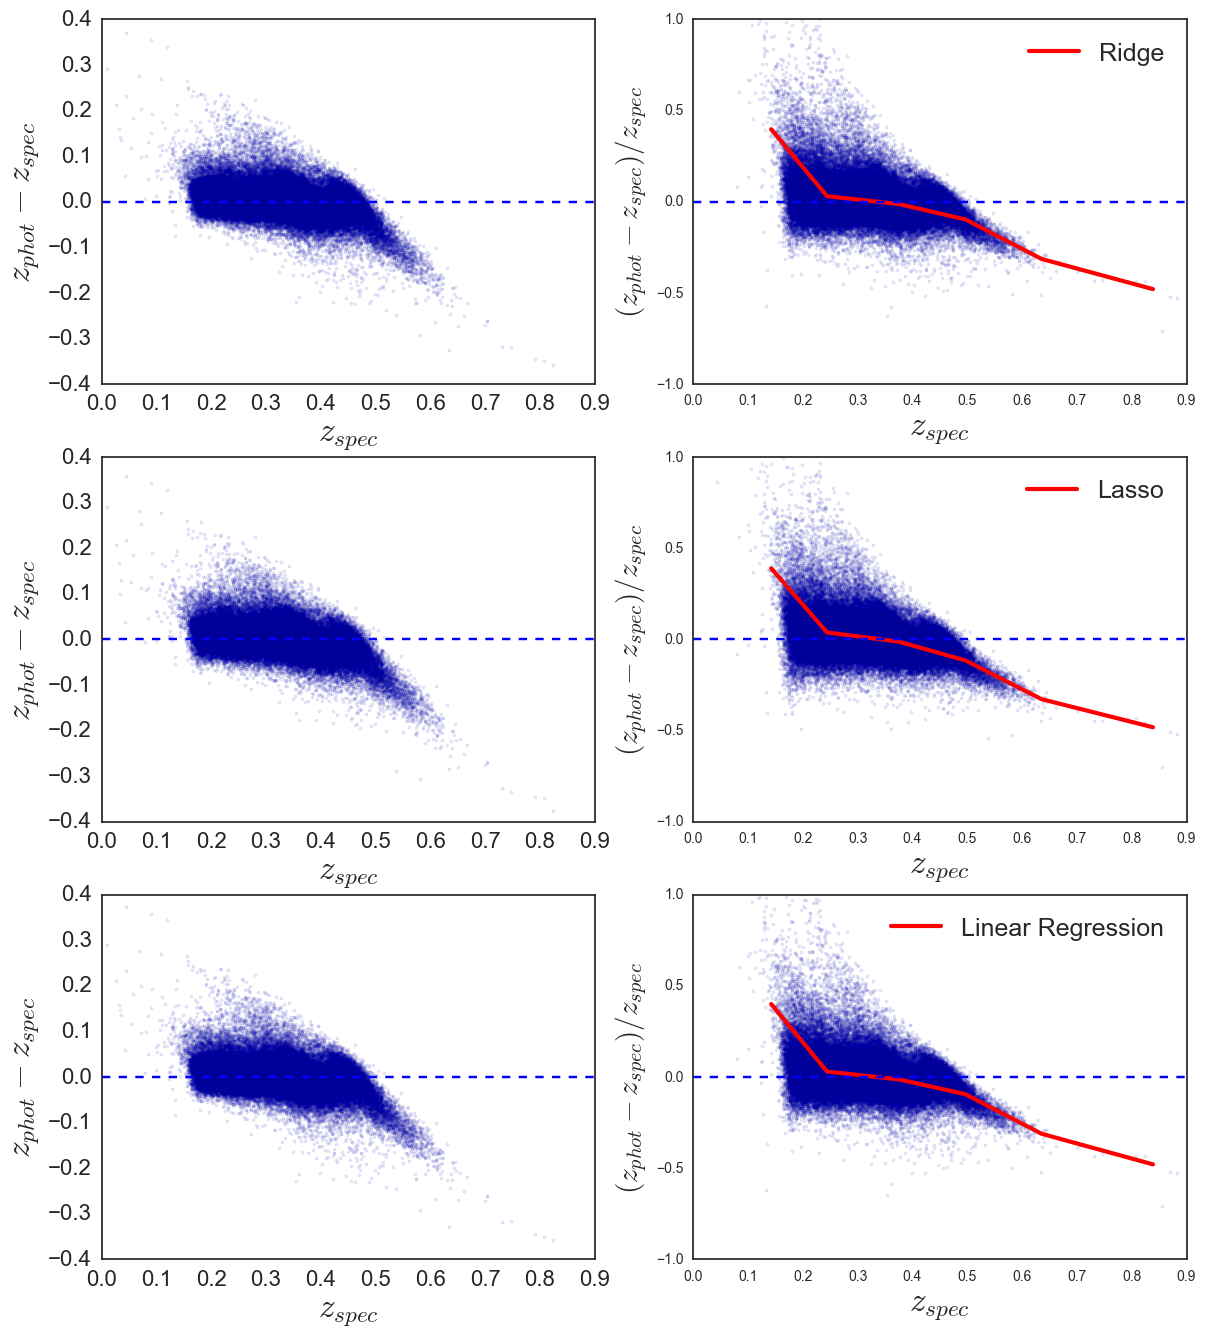

In [147]:
# Finally put together all the relevant plots of this notebook that I will include on the report as only one image

fig, ((axA, axB), (axC, axD), (axE, axF)) = plt.subplots(nrows = 3, ncols = 2,figsize = (14,16))

axA.scatter(Zspec, residuals_ridge, marker='.', alpha=0.1)
axA.set_xlabel(r'$z_{spec}$', size=24)
axA.set_ylabel(r'$z_{phot}-z_{spec}$', size=24, fontsize=16)
axA.tick_params(axis='both', which='major', labelsize=16)
axA.set_ylim(-0.4,0.4)
axA.set_xlim(0.0,0.9)
axA.axhline(y=0.0, linestyle= '--')


axB.scatter(Zspec, relative_residuals_ridge, marker='.', alpha=0.1)
axB.plot(Zspec_m_ridge, med_ridge, lw=3, color='red', label="Ridge")
axB.set_xlabel(r'$z_{spec}$', size=24)
axB.set_ylim(-1,1)
axB.set_xlim(0.0,0.9)
axB.axhline(y=0.0, linestyle= '--')
axB.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=21)
axB.legend(prop={'size': 18})

axC.scatter(Zspec, residuals_lasso, marker='.', alpha=0.1)
axC.set_xlabel(r'$z_{spec}$', size=24)
axC.set_ylabel(r'$z_{phot}-z_{spec}$', size=24, fontsize=16)
axC.tick_params(axis='both', which='major', labelsize=16)
axC.set_ylim(-0.4,0.4)
axC.set_xlim(0.0,0.9)
axC.axhline(y=0.0, linestyle= '--')

axD.scatter(Zspec, relative_residuals_lasso, marker='.', alpha=0.1)
axD.plot(Zspec_m_lasso, med_lasso, lw=3, color='red', label="Lasso")
axD.set_xlabel(r'$z_{spec}$', size=24)
axD.set_ylim(-1,1)
axD.set_xlim(0.0,0.9)
axD.axhline(y=0.0, linestyle= '--')
axD.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=21)
axD.legend(prop={'size': 18})

axE.scatter(Zspec, residuals_lin, marker='.', alpha=0.1)
axE.set_xlabel(r'$z_{spec}$', size=24)
axE.set_ylabel(r'$z_{phot}-z_{spec}$', size=24, fontsize=16)
axE.tick_params(axis='both', which='major', labelsize=16)
axE.set_ylim(-0.4,0.4)
axE.set_xlim(0.0,0.9)
axE.axhline(y=0.0, linestyle= '--')


axF.scatter(Zspec, relative_residuals_lin, marker='.', alpha=0.1)
axF.plot(Zspec_m_lin, med_lin, lw=3, color='red', label="Linear Regression")
axF.set_xlabel(r'$z_{spec}$', size=24)
axF.set_ylim(-1,1)
axF.set_xlim(0.0,0.9)
axF.axhline(y=0.0, linestyle= '--')
axF.set_ylabel(r'$(z_{phot}-z_{spec})/z_{spec}$', size=21)
axF.legend(prop={'size': 18})
plt.savefig('8.png')

# 2.c Generalization error

In [149]:
# Stack the data of the file B

MB = np.vstack((B['mag_r'].values,B['i'].values,B['z'].values, B['g'].values,B['u'].values)).T
zspec_B = B['z_spec'].values

# I decided to do it for the three methods (Ridge, Lasso and LR) and in the three cases the procedures is basically
# the same, I have the model applied on data A and then use this new model to get the generalization error 
# from data B.

# For Linear Regression:

In [150]:
model = LinearRegression(fit_intercept=True)
modelA = model.fit(M, Zspec)
Zpred_A = modelA.predict(M)
Error_lin = np.median( np.abs( (Zspec - Zpred_A)/(1.0 + Zspec) ) )
print("Training error is:\n\n Etheta = {}\n".format(Error_lin))

Zpred_B = modelA.predict(MB)
Gen_err = np.median(np.abs((zspec_B - Zpred_B)/(1 + zspec_B)))

print("Generalization Error:\n\n Etheta = {}\n".format(Gen_err))

Training error is:

 Etheta = 0.0145588611233

Generalization Error:

 Etheta = 0.0146014572286



# For Ridge regression

In [151]:
model = Ridge(alpha=0.0001, fit_intercept=True, normalize=True)
modelA = model.fit(M, Zspec)
Zpred_A = modelA.predict(M)
Error_lin = np.median( np.abs( (Zspec - Zpred_A)/(1.0 + Zspec) ) )
print("Training error is:\n\n Etheta = {}\n".format(Error_lin))

Zpred_B = modelA.predict(MB)
Gen_err = np.median(np.abs((zspec_B - Zpred_B)/(1 + zspec_B)))

print("Generalization Error:\n\n Etheta = {}\n".format(Gen_err))

Training error is:

 Etheta = 0.0146096803208

Generalization Error:

 Etheta = 0.0146471352295



# For Lasso regression

In [152]:
model = Lasso(alpha=0.000001, fit_intercept=True, normalize=True)
modelA = model.fit(M, Zspec)
Zpred_A = modelA.predict(M)
Error_lin = np.median( np.abs( (Zspec - Zpred_A)/(1.0 + Zspec) ) )
print("Training error is:\n\n Etheta = {}\n".format(Error_lin))

Zpred_B = modelA.predict(MB)
Gen_err = np.median(np.abs((zspec_B - Zpred_B)/(1 + zspec_B)))

print("Generalization Error:\n\n Etheta = {}\n".format(Gen_err))

Training error is:

 Etheta = 0.0155897203138

Generalization Error:

 Etheta = 0.0155995565379

